# Comparison between Sersic and B+D models

This notebook compares the results from SourceXtractor++ between the Sersic and the Bulge+Disk models.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
import dja_sepp
from dja_sepp.utils import color_dict, channel_color_dict, channel_dict

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

First, we load the DJA catalog and the SE++ catalog.

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'ceers-full-grizli-v7.2'
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/sersic_rg4/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_sersic = Table(hdul[1].data)
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/B+D/*sci_tile-full_sepp_cat.fits")[0]) as hdul:
    phot_BD = Table(hdul[1].data)

We compare the number of sources in each catalog :
* Complete DJA catalog
* Complete SE++ catalog
* Cutout of the DJA catalog with the same footprint as the SE++ catalog

In [3]:
print(f"Sources in Sersic catalog  : {len(phot_sersic)}")
print(f"Sources in B+D catalog : {len(phot_BD)}")

Sources in Sersic catalog  : 340554
Sources in B+D catalog : 340627


We do a scatter plot of all the sources to visually see the footprint of the catalogs.

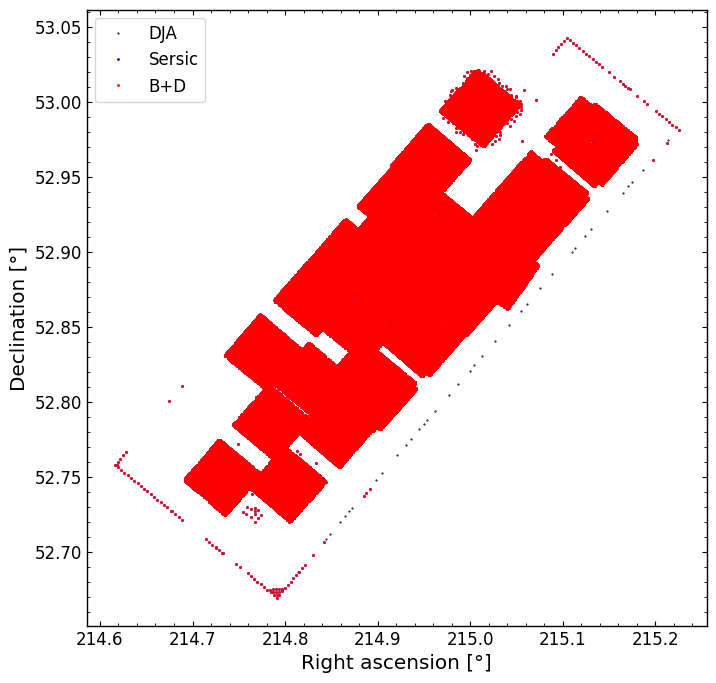

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_sersic['world_centroid_alpha'], phot_sersic['world_centroid_delta'], marker='o', ls='', ms=1, c='b', label='Sersic')
ax.plot(phot_BD['world_centroid_alpha'], phot_BD['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label='B+D')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.88, 214.95)
# ax.set_ylim(52.83, 52.88)
ax.legend()
plt.show()

We first cross-match the two catalogs with the DJA to compare them later...

In [5]:
coord_dja = SkyCoord(phot_dja['ra']*u.degree, phot_dja['dec']*u.degree)
coord_sersic = SkyCoord(phot_sersic['world_centroid_alpha']*u.degree, phot_sersic['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD['world_centroid_alpha']*u.degree, phot_BD['world_centroid_delta']*u.degree)
idx_sersic, d2d_sersic, _ = coord_sersic.match_to_catalog_sky(coord_dja)
idx_BD, d2d_BD, _ = coord_BD.match_to_catalog_sky(coord_dja)

... and we remove the matches further than `max_sep`.

Matched sources (Sersic) : 66559
Matched sources (B+D) : 66553


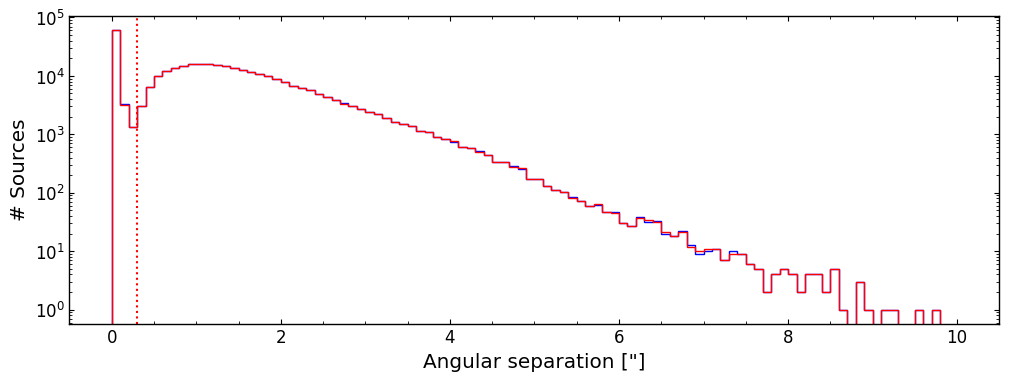

In [6]:
max_sep = 0.3*u.arcsec
phot_sersic_match = phot_sersic[d2d_sersic<max_sep]
phot_BD_match = phot_BD[d2d_BD<max_sep]
print(f"Matched sources (Sersic) : {len(phot_sersic_match)}")
print(f"Matched sources (B+D) : {len(phot_BD_match)}")

fig, ax = plt.subplots(figsize=(12,4))
ax.hist(d2d_sersic.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='b', histtype='step')
ax.hist(d2d_BD.to(u.arcsec), bins=100, range=(0*u.arcsec,10*u.arcsec), color='r', histtype='step')
ax.axvline(max_sep.value, color='r', ls=':')
ax.set_yscale('log')
ax.set_xlabel('Angular separation ["]')
ax.set_ylabel('# Sources')
plt.show()

And then we match the two (Sersic and B+D) catalogs.

In [7]:
coord_sersic = SkyCoord(phot_sersic_match['world_centroid_alpha']*u.degree, phot_sersic_match['world_centroid_delta']*u.degree)
coord_BD = SkyCoord(phot_BD_match['world_centroid_alpha']*u.degree, phot_BD_match['world_centroid_delta']*u.degree)
idx, d2d, _ = coord_sersic.match_to_catalog_sky(coord_BD)
phot_sersic_match = phot_sersic_match[d2d<max_sep]
phot_BD_match = phot_BD_match[idx][d2d<max_sep]

In [8]:
print(f"{'B+D sources':<32} : {len(phot_BD)}")
print(f"{'Sérsic sources':<32} : {len(phot_sersic)}")
print(f"{'DJA sources':<32} : {len(phot_dja)}")
print(f"{'Matched (Sérsic/B+D/DJA) sources':<32} : {len(phot_BD_match)}")
print(f"{'SE++ coverage of DJA':<32} : {len(phot_BD_match)/len(phot_dja)*100:.1f}%")

B+D sources                      : 340627
Sérsic sources                   : 340554
DJA sources                      : 76637
Matched (Sérsic/B+D/DJA) sources : 66528
SE++ coverage of DJA             : 86.8%


## Magnitude comparison

Now that the sources are matched, it's possible to compare the values of the two different models.

First, we compare the magnitudes.

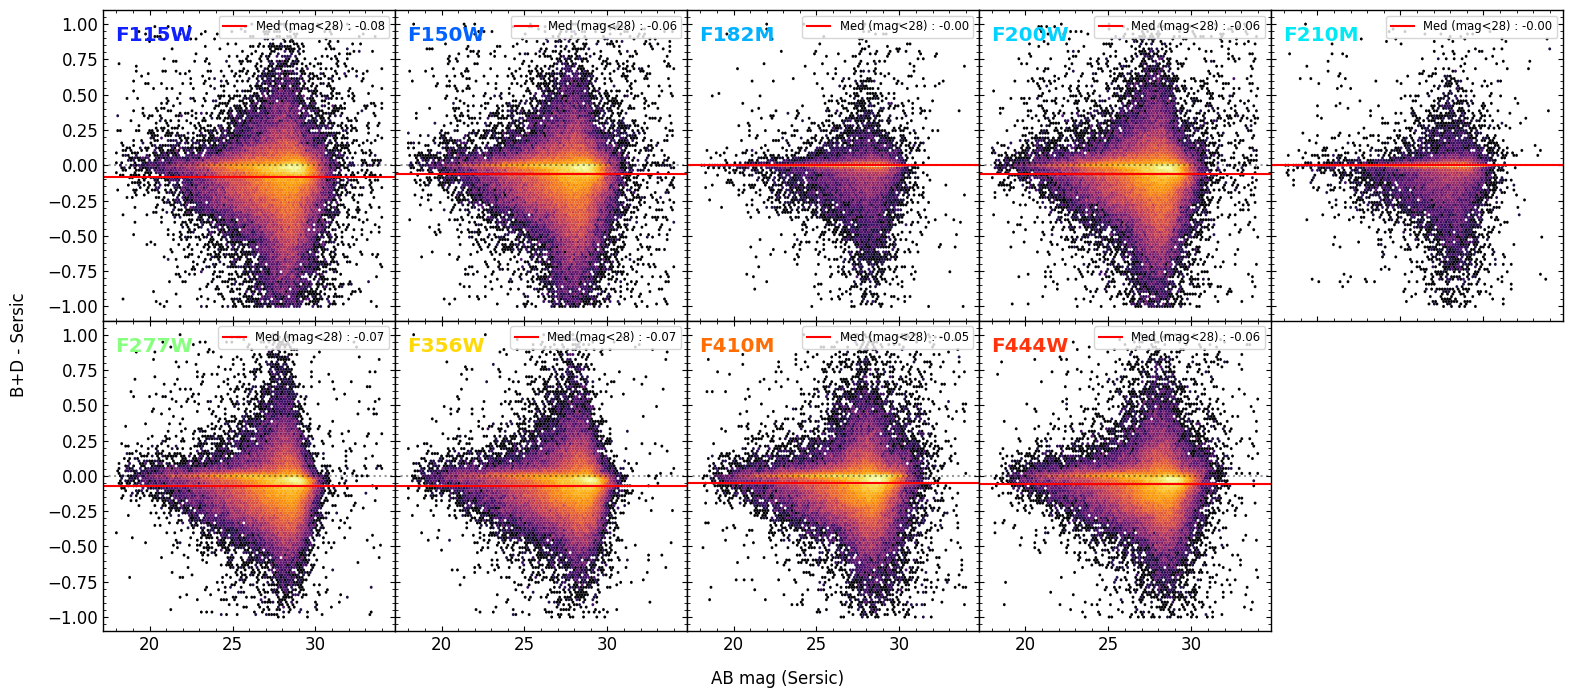

In [9]:
filter_list = dja_sepp.utils.get_filter_list(phot_sersic.keys())

def plot_mag(ax, filter, phot_sersic, phot_BD):
    ax.axhline(0, color='k', alpha=0.4, ls=':')
    ZP = (1*u.nJy).to(u.ABmag).value
    mag_sersic = ZP - 2.5*np.log10(phot_sersic[f'FLUX_MODEL_{filter.upper()}']*10)
    mag_BD = ZP - 2.5*np.log10(phot_BD[f'FLUX_MODEL_{filter.upper()}']*10)
    delta_28 = np.nanmedian((mag_BD-mag_sersic)[mag_BD<28])

    ax.hexbin(mag_sersic, mag_BD - mag_sersic, mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(18,34,-1,1), lw=0.01)
    ax.axhline(delta_28, color='r', label=f"Med (mag<28) : {delta_28:.2f}")
    ax.text(0.04, 0.9, filter.upper(), transform=ax.transAxes, fontsize='x-large', fontweight='bold', color=color_dict[filter.upper()])
    ax.legend(loc='upper right', fontsize='small')

fig, axs = dja_sepp.utils.plot_group_filter(filter_list, plot_mag, phot_sersic=phot_sersic_match, phot_BD=phot_BD_match)
fig.supylabel("B+D - Sersic")
fig.supxlabel("AB mag (Sersic)")
fig.tight_layout(rect=(0.02, -0.01, 1.0, 1.0))
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_B+DvSersic.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}_B+DvSersic.png", bbox_inches='tight', dpi=200)
plt.show()

## Clean-up

In [10]:
print(phot_sersic_match.keys())
print(len(phot_sersic_match.keys()))

['pixel_centroid_x', 'pixel_centroid_y', 'world_centroid_alpha', 'world_centroid_delta', 'source_id', 'detection_id', 'group_id', 'group_stamp_top', 'group_stamp_left', 'group_stamp_width', 'group_stamp_height', 'source_flags', 'n_detected_pixels', 'n_core_pixel', 'APER_flux', 'APER_flux_err', 'APER_mag', 'APER_mag_err', 'APER_flags', 'auto_flux', 'auto_flux_err', 'auto_mag', 'auto_mag_err', 'auto_flags', 'flux_radius', 'snrratio', 'ellipse_a', 'ellipse_b', 'ellipse_theta', 'ellipse_cxx', 'ellipse_cyy', 'ellipse_cxy', 'area', 'elongation', 'ellipticity', 'fmf_reduced_chi_2', 'fmf_iterations', 'fmf_stop_reason', 'fmf_duration', 'fmf_flags', 'fmf_chi2_per_meta', 'fmf_iterations_per_meta', 'fmf_meta_iterations', 'X_MODEL', 'X_MODEL_err', 'Y_MODEL', 'Y_MODEL_err', 'RA_MODEL', 'RA_MODEL_err', 'DEC_MODEL', 'DEC_MODEL_err', 'RADIUS', 'RADIUS_err', 'AXRATIO', 'AXRATIO_err', 'ANGLE', 'ANGLE_err', 'E1', 'E1_err', 'E2', 'E2_err', 'SERSIC', 'SERSIC_err', 'X_SERSIC', 'X_SERSIC_err', 'DET-IMG_RADIUS

In [51]:
cat = phot_sersic_match
# cat = cat[(cat['SERSIC']<0.361)&(cat['SERSIC']>0.359)]
cat = cat[np.abs(cat['SERSIC']-0.36)>1e-4]

keys = phot_sersic_match.keys()
keys = ['AXRATIO', 'E1', 'E2', 'snrratio']
print(keys)

['AXRATIO', 'E1', 'E2', 'snrratio']


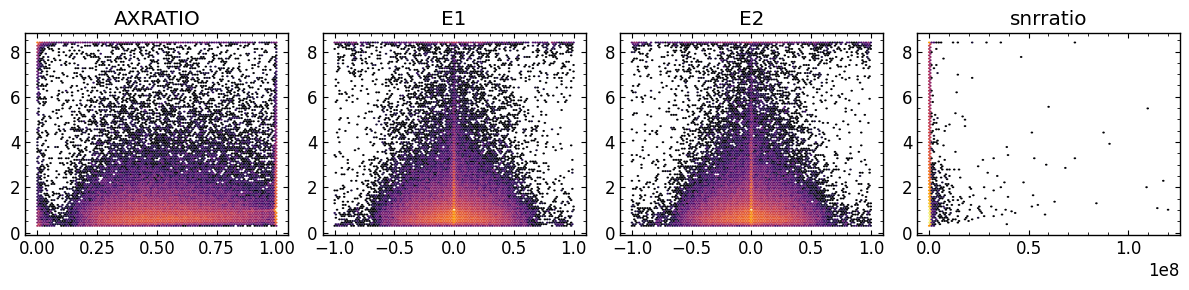

In [52]:
fig, axs = plt.subplots(max(1,len(keys)//4),4,figsize=(12,3*max(1,len(keys)//4)))
for i, key in enumerate(keys):
    ax = axs.flatten()[i]
    try:
        # ax.hist(cat[key], bins=50, histtype='step', log=True, color='orangered')
        ax.hexbin(cat[key], cat['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', lw=0.01)
    except:
        pass
    ax.set_title(key)
fig.tight_layout()
plt.show()

## Morphological distributions

As a sanity check, we can also look at some morphological distributions to look for any anomalies. Here we look at the radius, the aspect ratio and the Sersic index versus the magnitude (in the F277W band) for each source.

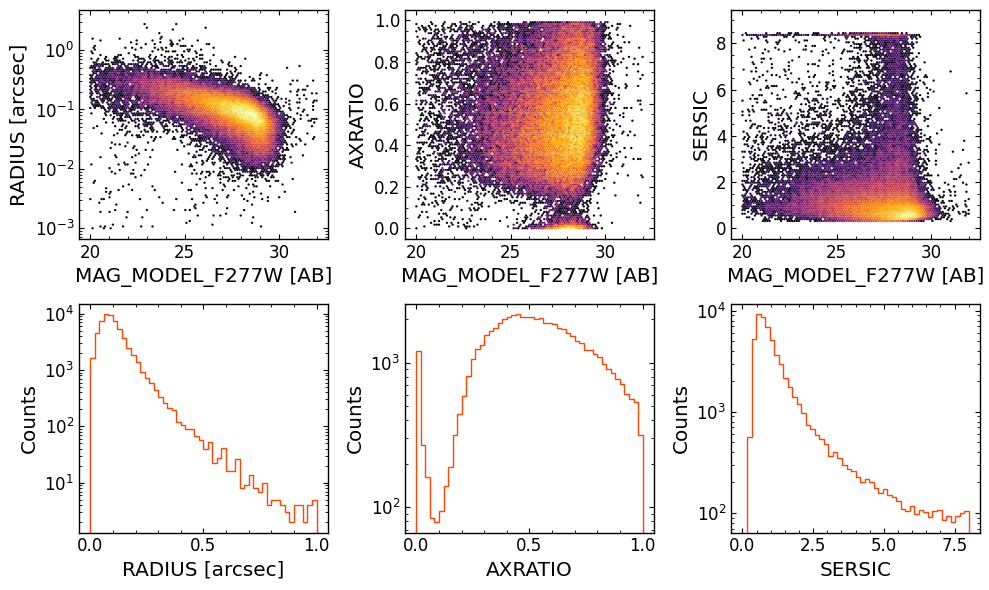

In [56]:
# sersic_rg4

cat = phot_sersic_match
# cat = phot_sersic[phot_sersic['RADIUS']*3600>0.01]
# cat = cat[(cat['RADIUS']*3600>5e-3)&(cat['SERSIC']<8.3)]
cat = cat[cat['AXRATIO']<0.99]
cat = cat[np.abs(cat['SERSIC']-0.36)>1e-4]

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,9), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(cat['RADIUS']*3600, bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(cat['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(cat['SERSIC'], bins=50, range=(0,8), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-sersic_rg4_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

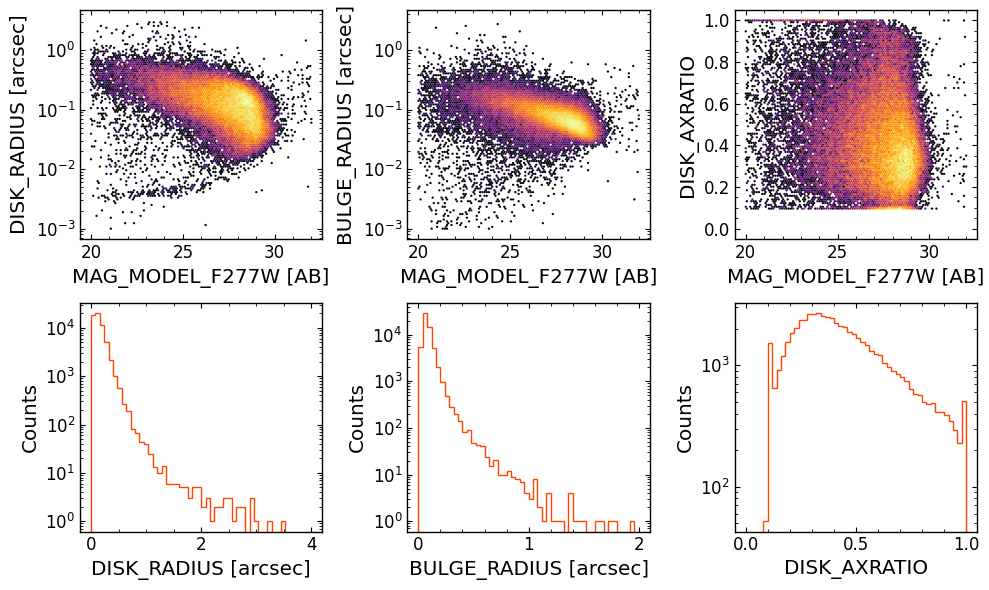

In [59]:
# B+D

cat = phot_BD_match
# cat = phot_BD
cat = cat[(phot_sersic_match['AXRATIO']<0.99) & (np.abs(phot_sersic_match['SERSIC']-0.36)>1e-4)]

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[0,1].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,2].hexbin(cat[f'MAG_MODEL_{filter.upper()}'], cat['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("DISK_AXRATIO")

axs[1,0].hist(cat['DISK_RADIUS_deg']*3600, bins=50, range=(0,4), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("DISK_RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(cat['BULGE_RADIUS_deg']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("BULGE_RADIUS [arcsec]")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(cat['DISK_AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("DISK_AXRATIO")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/{field}/sepp/{field}-B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

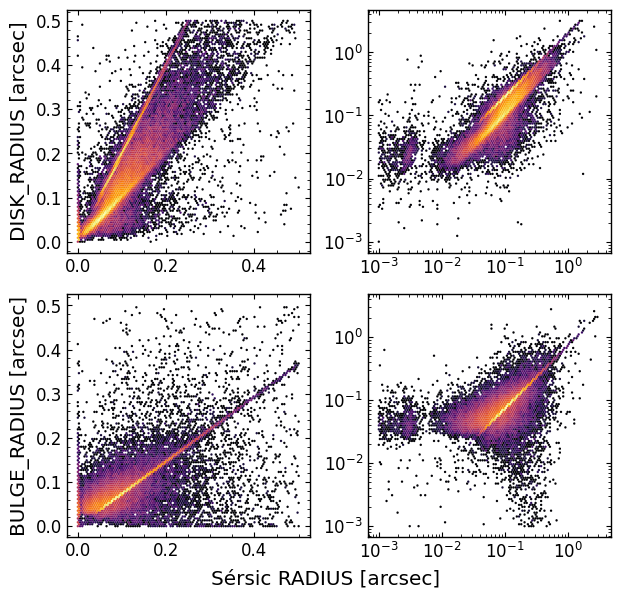

In [12]:
filter = 'f277w'
fig, axs = plt.subplots(2,2, figsize=(6,6))

axs[0,0].hexbin(phot_sersic_match['RADIUS']*3600, phot_BD_match['DISK_RADIUS_deg']*3600, 
                mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0, 0.5, 0, 0.5), lw=0.01)
axs[0,0].set_aspect('equal')
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[1,0].hexbin(phot_sersic_match['RADIUS']*3600, phot_BD_match['BULGE_RADIUS_deg']*3600, 
                mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(0, 0.5, 0, 0.5), lw=0.01)
axs[1,0].set_aspect('equal')
axs[1,0].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,1].hexbin(phot_sersic_match['RADIUS']*3600, phot_BD_match['DISK_RADIUS_deg']*3600, 
                mincnt=1, gridsize=100, cmap='inferno', bins='log', xscale='log', yscale='log', extent=(-3, 0.5, -3, 0.5), lw=0.01)
axs[0,1].set_aspect('equal')

axs[1,1].hexbin(phot_sersic_match['RADIUS']*3600, phot_BD_match['BULGE_RADIUS_deg']*3600, 
                mincnt=1, gridsize=100, cmap='inferno', bins='log', xscale='log', yscale='log', extent=(-3, 0.5, -3, 0.5), lw=0.01)
axs[1,1].set_aspect('equal')

fig.supxlabel("Sérsic RADIUS [arcsec]", size='x-large')
fig.tight_layout(rect=(-0.05, -0.03, 1.0, 1.0))
plt.show()

## Image comparisons

In [57]:
from astropy.visualization import ImageNormalize, ZScaleInterval, MinMaxInterval, LogStretch
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

filter = 'f444w'

hdu_data = fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*.fits")[0], memmap=True)[0]
hdu_model_BD = fits.open(glob.glob(f"{home}/fields/{field}/sepp/B+D/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True)[0]
hdu_model_sersic = fits.open(glob.glob(f"{home}/fields/{field}/sepp/sersic_rg4/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True)[0]

In [63]:
# Cutouts in images
center = SkyCoord('14h19m45s 52d54m00s', frame='icrs') # CEERS
size = u.Quantity((2.0,2.0), u.arcmin)
wcs = WCS(hdu_data.header)
cutout_data  = Cutout2D(hdu_data.data,  position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
cutout_model_BD = Cutout2D(hdu_model_BD.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
cutout_model_sersic = Cutout2D(hdu_model_sersic.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)

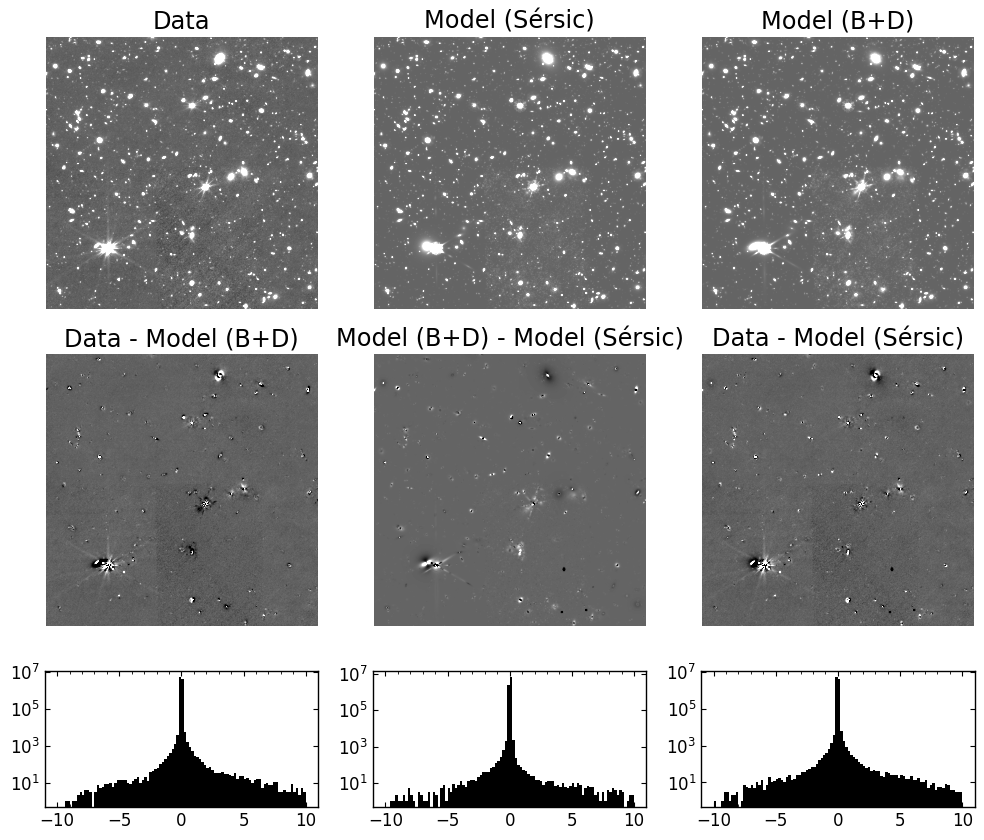

In [77]:
fig, axs = plt.subplots(3,3, figsize=(12,10), height_ratios=[1,1,0.5], width_ratios=[1,1,1])
#Plots data
norm = ImageNormalize(cutout_data.data, interval=ZScaleInterval())
axs[0,0].imshow(cutout_data.data, cmap='gray', origin='lower', norm=norm)
# dja_sepp.utils.add_good_scalebar(axs[0,0], cutout_data.wcs)
axs[0,0].set_axis_off()
axs[0,0].set_title("Data", size='x-large')
# Plots model (B+D)
axs[0,2].imshow(cutout_model_BD.data, cmap='gray', origin='lower', norm=norm)
axs[0,2].set_axis_off()
axs[0,2].set_title("Model (B+D)", size='x-large')
# Plots model (Sérsic)
axs[0,1].imshow(cutout_model_sersic.data, cmap='gray', origin='lower', norm=norm)
axs[0,1].set_axis_off()
axs[0,1].set_title("Model (Sérsic)", size='x-large')
# Plots residual (B+D)
resid_BD = cutout_data.data - cutout_model_BD.data
axs[1,0].imshow(resid_BD, cmap='gray', origin='lower', norm=norm)
axs[1,0].set_axis_off()
axs[1,0].set_title("Data - Model (B+D)", size='x-large')
# Plots residual (Sérsic)
resid_sersic = cutout_data.data - cutout_model_sersic.data
axs[1,2].imshow(resid_sersic, cmap='gray', origin='lower', norm=norm)
axs[1,2].set_axis_off()
axs[1,2].set_title("Data - Model (Sérsic)", size='x-large')
# Plots difference
difference = cutout_model_BD.data - cutout_model_sersic.data
axs[1,1].imshow(difference, cmap='gray', origin='lower', norm=norm)
axs[1,1].set_axis_off()
axs[1,1].set_title("Model (B+D) - Model (Sérsic)", size='x-large')
# Histogram residual (B+D)
axs[2,0].hist(resid_BD.flatten(), bins=100, range=(-10,10), log=True, color='k')
# Histogram residual (Sérsic)
axs[2,2].hist(resid_sersic.flatten(), bins=100, range=(-10,10), log=True, color='k')
# Histogram difference
axs[2,1].hist(difference.flatten(), bins=100, range=(-10,10), log=True, color='k')

# fig.tight_layout()
plt.show()